In [1]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
from tqdm import tqdm
from utils import *
from keras_dgl.layers import GraphCNN
import os
import pandas as pd
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
df = pd.read_csv('./Datasets/labels.csv')

In [3]:
files = os.listdir('./Datasets/matrices/')
names = []
for f in files:
    if '.npy' in f[2:]:
        names.append(f[2:])
names = list(set(names))

In [4]:
freq, masses = [],[]
df_names = df['name'].tolist()
for name in names:
    idx = df_names.index(name[:-4])
    freq.append(df['freq_10'][idx])
    masses.append(df['mass'][idx])

In [6]:
Feature_mat, Adj_mat = [],[]
for name in names:
    F = np.load(f'./Datasets/matrices/F_{name}')
    Feature_mat.append(F)
    A = np.load(f'./Datasets/matrices/A_{name}')
    Adj_mat.append(A)

In [16]:
n_max, f_max = 0,0 
for i in range(len(Feature_mat)):
    if n_max <= Feature_mat[i].shape[0]:
        n_max = Feature_mat[i].shape[0]
    elif f_max <= Feature_mat[i].shape[1]:
        f_max = Feature_mat[i].shape[1]
node_num, feature_num = n_max, f_max
print(node_num, feature_num)

9101 234


In [17]:
for i in range(len(Feature_mat)):
    A = np.pad(Adj_mat[i], ((0,n_max -len(Adj_mat[i]) )
                                     ,(0,n_max - len(Adj_mat[i])))
                                     ,'constant', constant_values=0)
    Adj_mat[i] = A.reshape((1,) + A.shape)

In [18]:
for i in range(len(Feature_mat)):
    F = np.pad(Feature_mat[i], ((0,n_max -len(Feature_mat[i]) )
                                     ,(0,f_max - Feature_mat[i].shape[1]))
                                     ,'constant', constant_values=0)
    
    Feature_mat[i] = F.reshape((1,) + F.shape)

In [19]:
print(Feature_mat[0].shape)
print(Adj_mat[0].shape)

(1, 9101, 234)
(1, 9101, 9101)


In [20]:
node_num, feature_num 

(9101, 234)

In [21]:
Y = np.array(freq)
Y = (Y-Y.min())/(Y.max()-Y.min()) 
Y = Y.reshape(-1,1)

In [22]:
Y.max(),Y.min()
Y.shape

(55, 1)

In [48]:
def GCN_layer(out_dim,inp,A):
    in_dim = inp.shape[-1]
    linear = tf.keras.layers.Dense(out_dim,input_shape=(None, in_dim),dtype='float64')
    H = linear(inp)
    H = tf.keras.layers.Dot(axes=(2, 1),dtype='float64')([A, H])
    H = layers.Activation('sigmoid',dtype='float64')(H)
    return H

def ReadOut(out_dim,inp):
    in_dim = inp.shape[-1]
    readout = tf.keras.layers.Dense(out_dim,input_shape=(None, in_dim),dtype='float64')
    out = tf.reduce_sum(readout(inp),2)
    act = layers.Activation('sigmoid',dtype='float64')(out)
    return act

In [52]:
def model_build():
    inp = layers.Input(shape=(node_num,feature_num),name='X')
    A = layers.Input(shape=(node_num,node_num),name='A')
    Hidden1 = GCN_layer(512,inp,A)
    Hidden1 = GCN_layer(256,Hidden1,A)
    Hidden1 = GCN_layer(128,Hidden1,A)
    readout = ReadOut(128,Hidden1)
    out = layers.Dense(128,dtype='float64')(readout)
    out = layers.BatchNormalization(dtype='float64')(out)
    out = layers.Activation('sigmoid',dtype='float64')(out)
    out = layers.Dense(128,dtype='float64')(out)
    out = layers.BatchNormalization(dtype='float64')(out)
    out = layers.Activation('sigmoid',dtype='float64')(out)
    out = layers.Dense(1, dtype='float64')(out)
    return Model([inp,A],out)

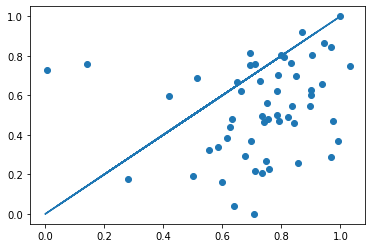

0 0.26027461282739583


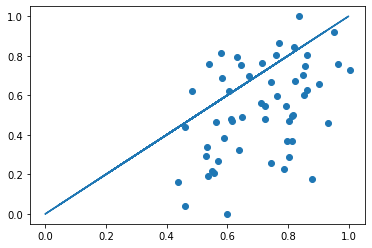

1 0.22015422013672917


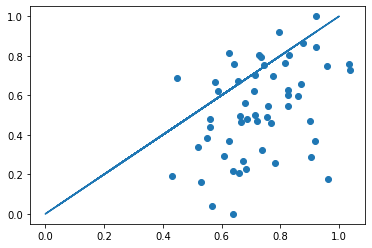

2 0.2192560438617048


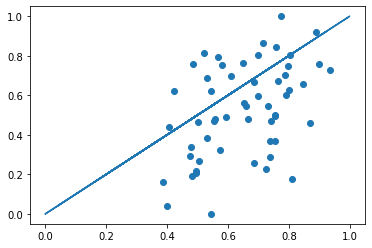

3 0.22000541812316937


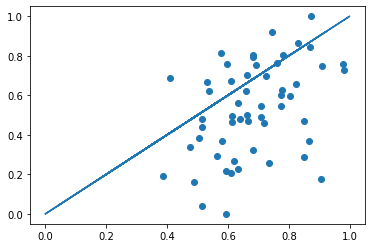

4 0.21905959397977726


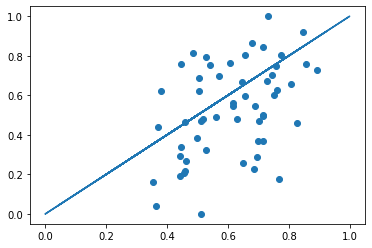

5 0.21985614177855578


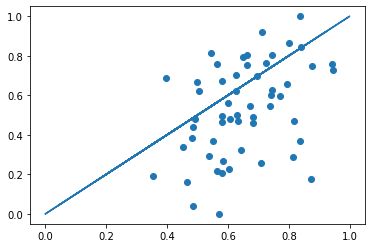

6 0.21886475702155042


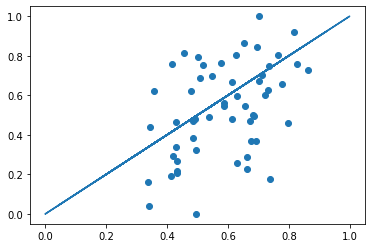

7 0.2197080845182592


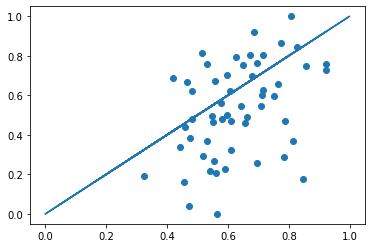

8 0.2186720414171842


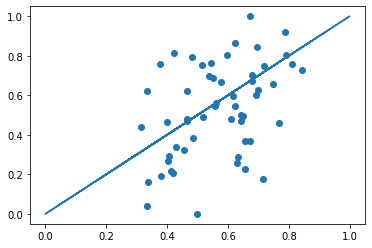

9 0.2195619532499801


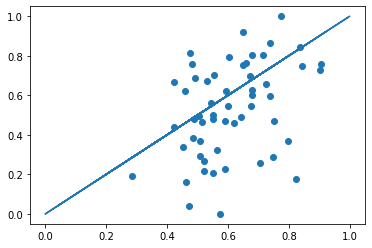

10 0.21848172237249938


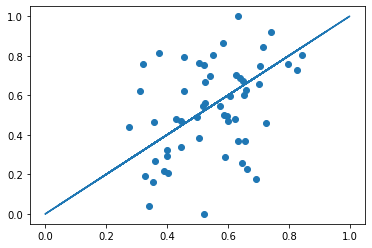

11 0.21941807695071805


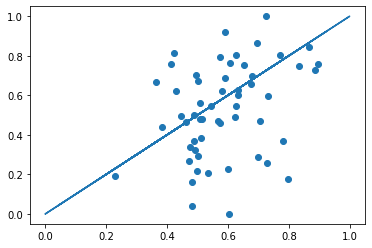

12 0.2182939383793961


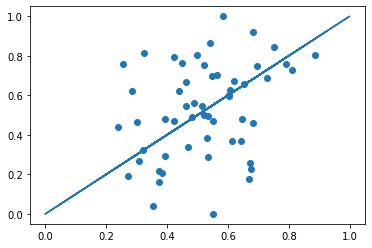

13 0.21927661567249082


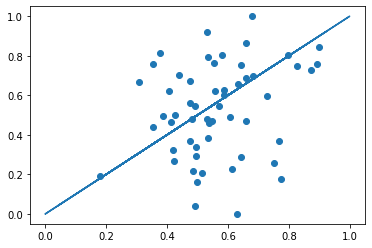

14 0.21810874927958304


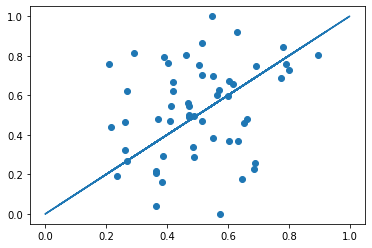

15 0.2191376548937776


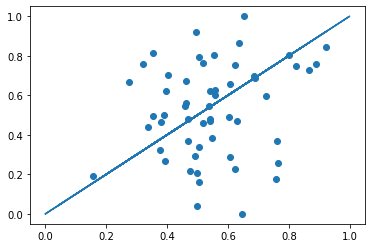

16 0.21792618242854422


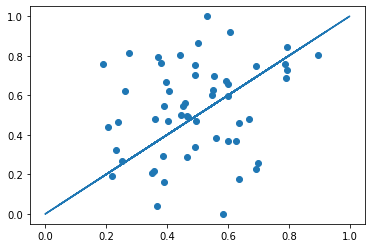

17 0.2190012322654101


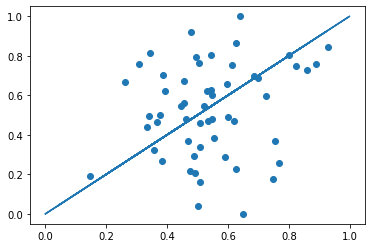

18 0.21774623233147644


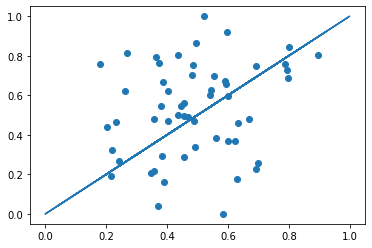

19 0.21886735296892848


In [55]:
model = model_build()
optimizer = Adam(lr=0.002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)
model.compile(loss='mae',optimizer=optimizer)

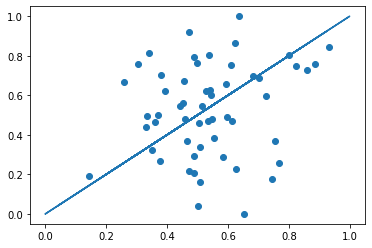

0 0.21756887556138363


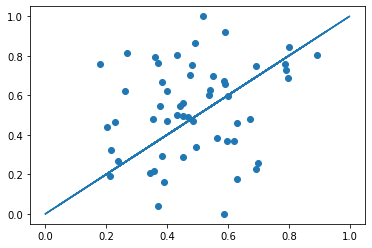

1 0.21873600221323697


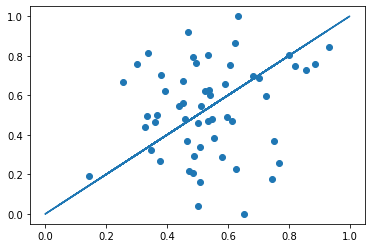

2 0.21739407530562443


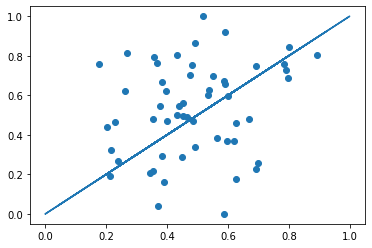

3 0.21860714799047193


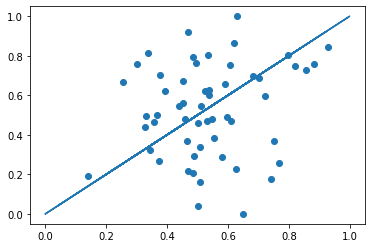

4 0.2172217875634405


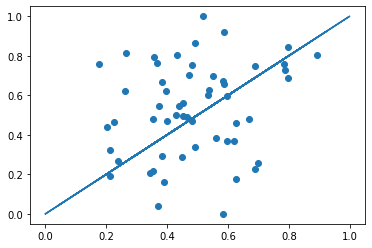

5 0.2184807548257099


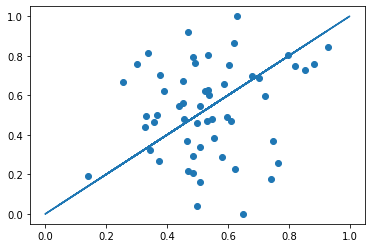

6 0.21705195604908195


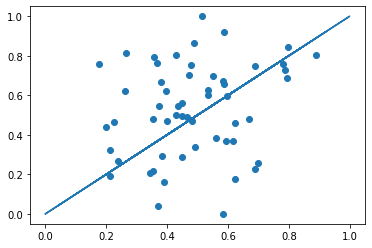

7 0.21835676881601102


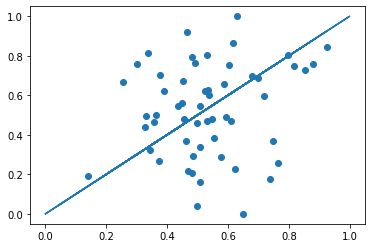

8 0.216884516780688


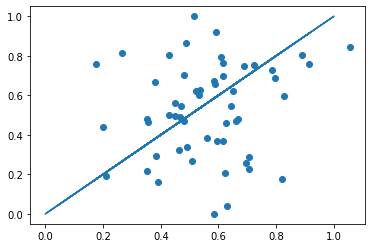

9 0.22339069792916152


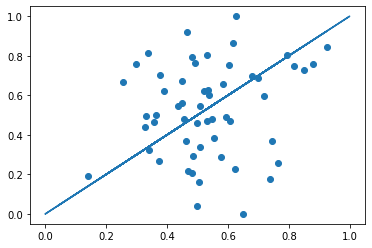

10 0.21672991861335256


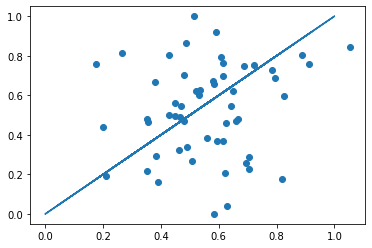

11 0.22329372369091618


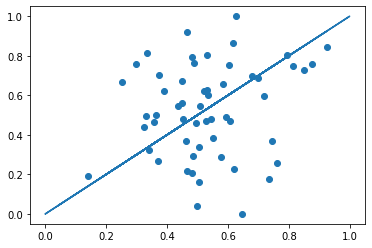

12 0.21657679598270493


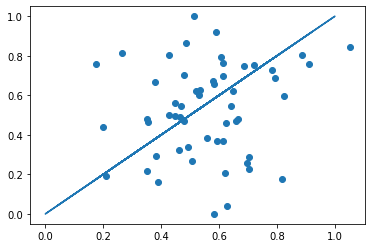

13 0.22319773361086845


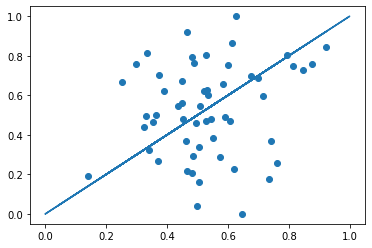

14 0.2164252297741107


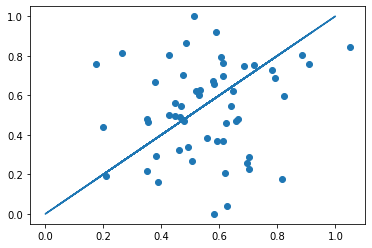

15 0.22310285107655958


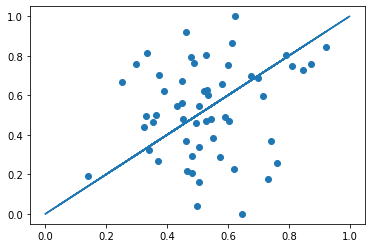

16 0.21627526904710315


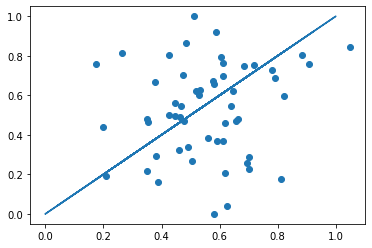

17 0.22300915182991463


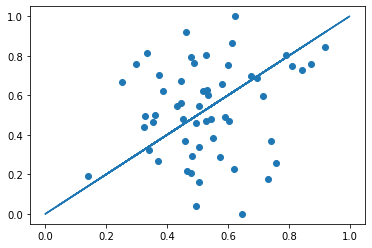

18 0.2161269378848374


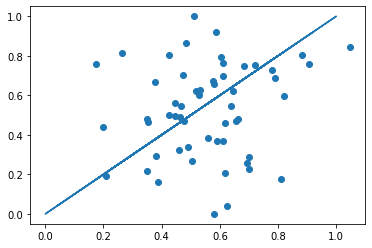

19 0.22291669413786042


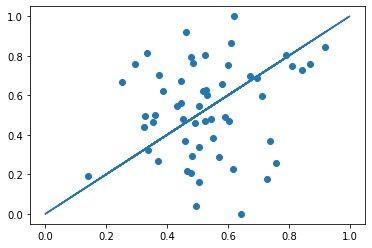

20 0.21598023866641927


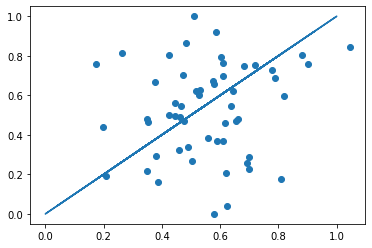

21 0.22282550656660036


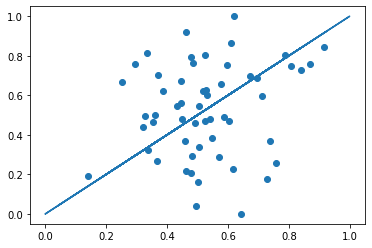

22 0.21583515938096257


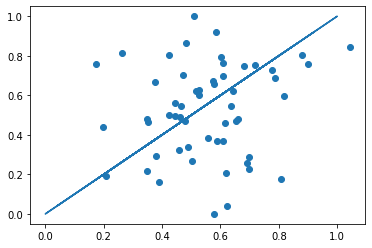

23 0.22273560063066808


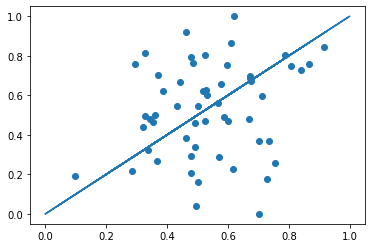

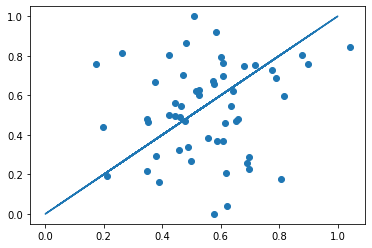

25 0.22263934168625962


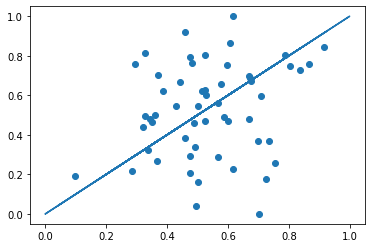

26 0.2147655427402986


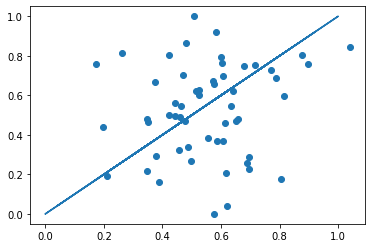

27 0.22254421050575646


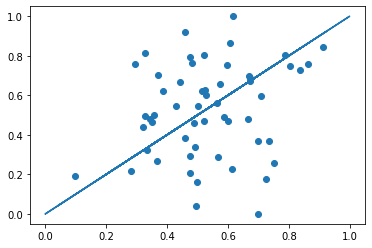

28 0.21459909743756395


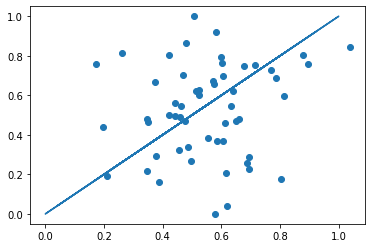

29 0.22245095951313323


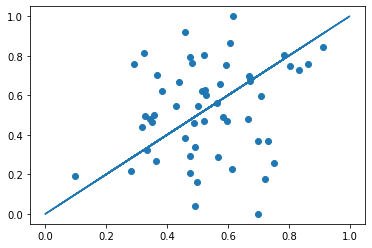

30 0.21443512215363708


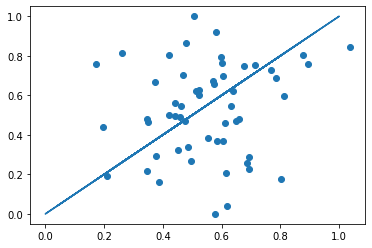

31 0.22235948494212193


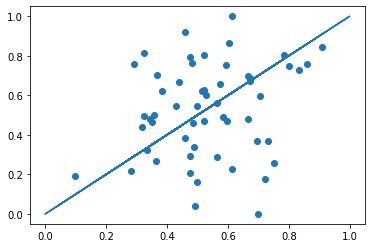

32 0.2142734564756128


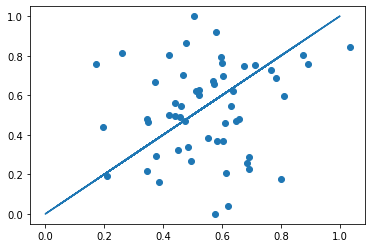

33 0.2222696794535626


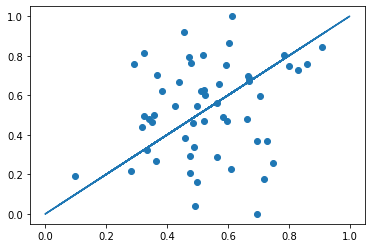

34 0.21411394995044578


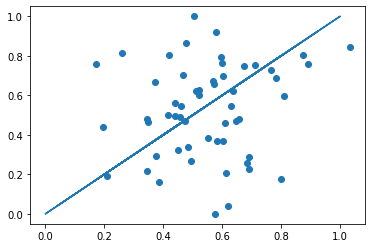

35 0.22218145259063352


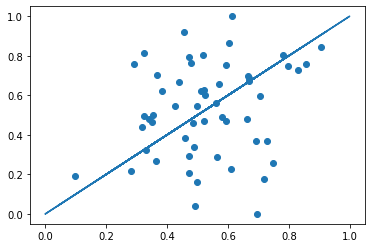

36 0.21395646681670438


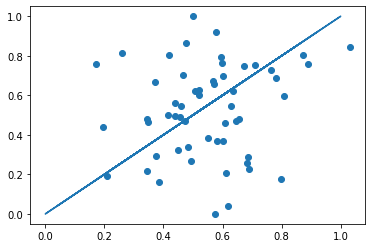

37 0.22209471198306843


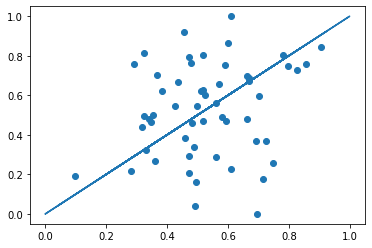

38 0.2138008808039806


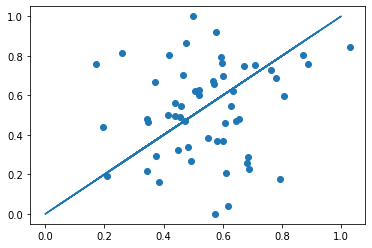

39 0.22200937534428455


In [ ]:
train_loss = []
for epoch in range(80):
    losses=[]
    y_trues = []
    y_preds = []
    for i in range(len(Y)):
        F = Feature_mat[i]
        A = Adj_mat[i]
        y = Y[i] 
        loss = model.train_on_batch([F,A],y)
        losses.append(loss)
        y_true = Y[i]
        y_hat = model([Feature_mat[i],Adj_mat[i]])
        #print(loss, y_true,y_hat.numpy())
        y_trues.append(y_true)
        y_preds.append(y_hat)
    plt.plot(y_trues,y_trues)
    plt.scatter(y_preds,y_trues)
    plt.show()
     
    train_loss.append(np.mean(losses))
    print(epoch, np.mean(losses))

In [ ]:
preds = []
trues = []
for i in tqdm(range(100)):
    try:
        F = Feature_mat[i]
        A = Adj_mat[i]
        y = Y[i]
        pred_y= model.predict([F,A])
        preds.append(pred_y)
        trues.append(y)
    except:
        pass

In [35]:
i = 0
for i in range(10):
    F = Feature_mat[i]
    A = Adj_mat[i]
    y = Y[i] 
    y_hat= model.predict([F,A])
    print(y,y_hat)

[0.72734383] [[0.51273022]]
[0.75823896] [[0.51273022]]
[0.17836543] [[0.51273022]]
[0.59725702] [[0.51273022]]
[0.32543439] [[0.51273022]]
[0.75494338] [[0.51273022]]
[0.76321449] [[0.51273022]]
[0.84539313] [[0.51273022]]
[0.28784261] [[0.51273022]]
[0.54835581] [[0.51273022]]


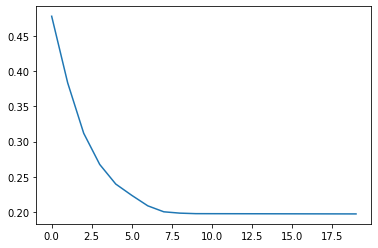

In [37]:
plt.plot(np.arange(len(train_loss)),train_loss)